In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import os
import re
import string
import random
import tensorflow_datasets as tfds
import pickle
from keras.layers.normalization import BatchNormalization

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.merge import concatenate

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/sentences_file.txt',sep='\t',header = None)

In [ ]:
len_of_sentence = {}
word_freq = {}
for sen in df[0]:
  list_of_words = sen.split()

  length = len(list_of_words)
  if(length not in len_of_sentence.keys()):
    len_of_sentence[length] = 0
  len_of_sentence[length] += 1

  for word in list_of_words:
    if(word not in word_freq.keys()):
      word_freq[word] = 0
    word_freq[word] += 1


In [ ]:
vocab_size = len(word_freq)

In [ ]:
len(word_freq)

28374

In [ ]:
train = tf.data.TextLineDataset("/content/drive/MyDrive/data/sentences_file.txt")

In [ ]:
def custom_standard(input_string):
    return tf.strings.lower(input_string)

In [ ]:
vectorize_layer = TextVectorization(
   standardize=custom_standard,
    max_tokens=int((99.5/100)*vocab_size),
    output_mode="int",
)

In [ ]:
vectorize_layer.adapt(train)

In [ ]:
vocab = vectorize_layer.get_vocabulary()
vocab_size = len(vocab)

In [ ]:
ix_to_vocab = {}
for i in range(len(vocab)):
  ix_to_vocab[vocab[i]] = i

In [ ]:
vocab_size

28232

In [ ]:
def prepare_dataset(text):
    '''
    text = [1,2,3,4,5] seq_len = 4
    x = [1,2,3,4] y = [2,3,4,5]
    '''
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

In [ ]:
train_ds = train.map(prepare_dataset) # train_ds[0] = tuple(x[0],y[0])

In [ ]:
tokenised_sen = []
for i in train_ds:
  tokenised_sen.append(i.numpy().reshape(-1,))

In [ ]:
tokenised_sen[:2]

[array([  18,    4,  193,   19,   48,   28,  216,   87,  221,    5,  780,
        1054,   19,   13,  922, 1641, 3479,   16]),
 array([  716, 23307,     2,  6375,   160,    72,    25,  1336,   583])]

In [ ]:
f = open("/content/drive/MyDrive/data/lid_file.txt")
iter = 0
lids = []
for i in f:
  lids.append( [int(t) for t in i.split()]   )
f.close()

In [ ]:
def get_x1_x2_y(tokenised_sen,lids,maxlen,step):
  final_x1 = []
  final_x2 = []
  final_y = []
  iter = 0
  for d in tokenised_sen:
    l = d.shape[0]
    for i in range(0,l-maxlen-1,step):
      final_x1.append(d[i:i+maxlen])
      final_x2.append(lids[iter][i:i+maxlen])
      final_y.append(d[i+1:i+maxlen+1])
    iter += 1
  return np.array(final_x1).reshape(len(final_x1),len(final_x1[0])),np.array(final_x2).reshape(len(final_x2),len(final_x2[0])),np.array(final_y).reshape(len(final_y),len(final_y[0]))

In [ ]:
maxlen = 5 
step = 1
fx1,fx2,fy = get_x1_x2_y(tokenised_sen,lids,maxlen,step)

## building model architecture

In [ ]:
def get_model(seq_length,embed_dim,vocab_size,lstm_cells,dense_cells):
  inputs1 = tf.keras.layers.Input(shape=(seq_length))
  embed1 = tf.keras.layers.Embedding(vocab_size,embed_dim, input_length=seq_length)(inputs1)
  lstm1 = tf.keras.layers.LSTM(lstm_cells, return_sequences=True)(embed1)
  dense1 = tf.keras.layers.Dense(dense_cells, activation='relu')(lstm1)

  inputs2 = tf.keras.layers.Input(shape=(seq_length))
  embed2 = tf.keras.layers.Embedding(vocab_size,embed_dim, input_length=seq_length)(inputs2)
  lstm2 = tf.keras.layers.LSTM(lstm_cells, return_sequences=True)(embed2)
  dense2 = tf.keras.layers.Dense(dense_cells, activation='relu')(lstm2)

  merged = concatenate([dense1, dense2])
  dense_merged = tf.keras.layers.Dense(dense_cells,activation='relu')(merged)

  word_dense = tf.keras.layers.Dense(vocab_size,activation='softmax')(dense_merged)

  model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=word_dense)
  return model

## model3 summary

In [ ]:
mdl_3 = get_model(seq_length=5,embed_dim=512,vocab_size=vocab_size,lstm_cells=512,dense_cells=512)
optimizer = keras.optimizers.RMSprop(lr=0.01)
mdl_3.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
mdl_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 512)       14454784    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 512)       14454784    input_2[0][0]                    
______________________________________________________________________________________________

#building custom data generator

In [ ]:
class TextDataGenerator(keras.utils.Sequence):
    def __init__(self, input1,input2, target, sequence_length, vocab_size, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.input1 = input1
        self.input2 = input2
        self.target = target
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.input1) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        #print(indexes)
        sequences_batch = [self.input1[k] for k in indexes]
        lid_batch = [self.input2[k] for k in indexes]
        next_words_batch = [self.target[k] for k in indexes]

        X1 = np.array(sequences_batch)
        X2 = np.array(lid_batch)
        y = keras.utils.to_categorical(next_words_batch, num_classes=self.vocab_size)

        return [X1,X2], y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.input1))
        if self.shuffle == True:
           np.random.shuffle(self.indexes)

In [ ]:
datagen = TextDataGenerator(fx1,fx2,fy,5,vocab_size,512)

#Training and plotting loss graph of model-3

Epoch 1/10
478/478 [==============================] - 182s 311ms/step - loss: 7.9773
Epoch 2/10
478/478 [==============================] - 150s 314ms/step - loss: 6.3822
Epoch 3/10
478/478 [==============================] - 150s 313ms/step - loss: 5.9008
Epoch 4/10
478/478 [==============================] - 150s 313ms/step - loss: 5.5693
Epoch 5/10
478/478 [==============================] - 149s 311ms/step - loss: 5.3190
Epoch 6/10
478/478 [==============================] - 149s 311ms/step - loss: 5.1866
Epoch 7/10
478/478 [==============================] - 149s 311ms/step - loss: 5.0941
Epoch 8/10
478/478 [==============================] - 149s 311ms/step - loss: 5.0309
Epoch 9/10
478/478 [==============================] - 149s 312ms/step - loss: 4.9970
Epoch 10/10
478/478 [==============================] - 149s 312ms/step - loss: 4.9888


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_3/10/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_3/10/model/assets


Epoch 1/10
478/478 [==============================] - 149s 312ms/step - loss: 5.0433
Epoch 2/10
478/478 [==============================] - 148s 310ms/step - loss: 5.0453
Epoch 3/10
478/478 [==============================] - 149s 311ms/step - loss: 5.0535
Epoch 4/10
478/478 [==============================] - 148s 310ms/step - loss: 5.0592
Epoch 5/10
478/478 [==============================] - 148s 308ms/step - loss: 5.0865
Epoch 6/10
478/478 [==============================] - 148s 310ms/step - loss: 5.1106
Epoch 7/10
478/478 [==============================] - 147s 308ms/step - loss: 5.1515
Epoch 8/10
478/478 [==============================] - 146s 306ms/step - loss: 5.1626
Epoch 9/10
478/478 [==============================] - 148s 309ms/step - loss: 5.1856
Epoch 10/10
478/478 [==============================] - 148s 310ms/step - loss: 5.4577


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_3/20/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_3/20/model/assets


Epoch 1/10
478/478 [==============================] - 148s 309ms/step - loss: 5.4310
Epoch 2/10
478/478 [==============================] - 147s 308ms/step - loss: 5.5604
Epoch 3/10
478/478 [==============================] - 148s 310ms/step - loss: 5.4057
Epoch 4/10
478/478 [==============================] - 148s 310ms/step - loss: 5.4023
Epoch 5/10
478/478 [==============================] - 147s 308ms/step - loss: 5.3442
Epoch 6/10
478/478 [==============================] - 149s 312ms/step - loss: 5.3469
Epoch 7/10
478/478 [==============================] - 147s 307ms/step - loss: 5.3654
Epoch 8/10
478/478 [==============================] - 148s 310ms/step - loss: 5.3971
Epoch 9/10
478/478 [==============================] - 147s 307ms/step - loss: 5.4226
Epoch 10/10
478/478 [==============================] - 148s 309ms/step - loss: 5.4698


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_3/30/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_3/30/model/assets


Epoch 1/10
478/478 [==============================] - 147s 308ms/step - loss: 5.5193
Epoch 2/10
478/478 [==============================] - 147s 307ms/step - loss: 5.5799
Epoch 3/10
478/478 [==============================] - 147s 308ms/step - loss: 5.6658
Epoch 4/10
478/478 [==============================] - 146s 306ms/step - loss: 5.7887
Epoch 5/10
478/478 [==============================] - 147s 307ms/step - loss: 5.9343
Epoch 6/10
478/478 [==============================] - 147s 307ms/step - loss: 6.0594
Epoch 7/10
478/478 [==============================] - 147s 308ms/step - loss: 6.1186
Epoch 8/10
478/478 [==============================] - 147s 307ms/step - loss: 6.1420
Epoch 9/10
478/478 [==============================] - 147s 307ms/step - loss: 5.8193
Epoch 10/10
478/478 [==============================] - 146s 306ms/step - loss: 5.7697


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_3/40/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_3/40/model/assets


Epoch 1/10
478/478 [==============================] - 148s 310ms/step - loss: 5.7745
Epoch 2/10
478/478 [==============================] - 146s 306ms/step - loss: 5.7588
Epoch 3/10
478/478 [==============================] - 147s 308ms/step - loss: 5.8076
Epoch 4/10
478/478 [==============================] - 147s 308ms/step - loss: 5.7700
Epoch 5/10
478/478 [==============================] - 147s 308ms/step - loss: 5.7888
Epoch 6/10
478/478 [==============================] - 148s 309ms/step - loss: 5.8814
Epoch 7/10
478/478 [==============================] - 148s 309ms/step - loss: 5.8028
Epoch 8/10
478/478 [==============================] - 148s 309ms/step - loss: 5.7718
Epoch 9/10
478/478 [==============================] - 147s 307ms/step - loss: 5.7884
Epoch 10/10
478/478 [==============================] - 146s 306ms/step - loss: 5.8017


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_3/50/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_3/50/model/assets


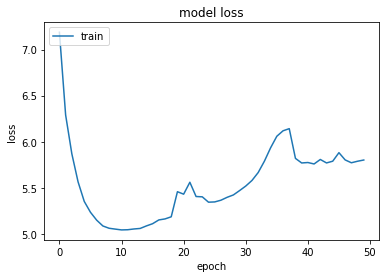

In [ ]:
loss_val = []
for i in range(5):
  hist = mdl_3.fit(datagen,
          steps_per_epoch=len(datagen),
          epochs=10,
          verbose=1)
  loss_val = loss_val+hist.history['loss']
  mdl_3.save("/content/drive/MyDrive/finally_final/mdl_3/"+str((i+1)*10)+"/model/")
plt.plot(loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
def get_model2(seq_length,embed_dim,vocab_size,lstm_cells,dense_cells):
  inputs1 = tf.keras.layers.Input(shape=(seq_length))
  embed1 = tf.keras.layers.Embedding(vocab_size,embed_dim, input_length=seq_length)(inputs1)
  lstm1 = tf.keras.layers.LSTM(lstm_cells, return_sequences=True)(embed1)
  lstm11 = tf.keras.layers.LSTM(lstm_cells, return_sequences=True)(lstm1)
  dense1 = tf.keras.layers.Dense(dense_cells, activation='relu')(lstm11)

  inputs2 = tf.keras.layers.Input(shape=(seq_length))
  embed2 = tf.keras.layers.Embedding(vocab_size,embed_dim, input_length=seq_length)(inputs2)
  lstm2 = tf.keras.layers.LSTM(lstm_cells, return_sequences=True)(embed2)
  
  dense2 = tf.keras.layers.Dense(dense_cells, activation='relu')(lstm2)

  merged = concatenate([dense1, dense2])
  dense_merged = tf.keras.layers.Dense(dense_cells,activation='relu')(merged)

  word_dense = tf.keras.layers.Dense(vocab_size,activation='softmax')(dense_merged)

  model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=word_dense)
  return model

## model-4 architecture

In [ ]:
mdl_4 = get_model2(seq_length=5,embed_dim=512,vocab_size=vocab_size,lstm_cells=512,dense_cells=512)
optimizer = keras.optimizers.RMSprop(lr=0.01)
mdl_4.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
mdl_4.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 5, 512)       14454784    input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 5, 512)       2099200     embedding_2[0][0]                
____________________________________________________________________________________________

In [ ]:
datagen2 = TextDataGenerator(fx1,fx2,fy,5,vocab_size,512)

#training and plotting loss graph of model-4

In [ ]:
loss_val = []
for i in range(5):
  hist = mdl_4.fit(datagen2,
          steps_per_epoch=len(datagen2),
          epochs=10,
          verbose=1)
  loss_val = loss_val+hist.history['loss']
  mdl_4.save("/content/drive/MyDrive/finally_final/mdl_4/"+str((i+1)*10)+"/model/")
plt.plot(loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Epoch 1/10
478/478 [==============================] - 157s 319ms/step - loss: 8.7381
Epoch 2/10
478/478 [==============================] - 149s 312ms/step - loss: 6.7367
Epoch 3/10
478/478 [==============================] - 149s 311ms/step - loss: 6.3572
Epoch 4/10
478/478 [==============================] - 148s 310ms/step - loss: 6.1066
Epoch 5/10
478/478 [==============================] - 150s 314ms/step - loss: 5.9032
Epoch 6/10
478/478 [==============================] - 150s 313ms/step - loss: 5.7534
Epoch 7/10
478/478 [==============================] - 152s 317ms/step - loss: 5.6750
Epoch 8/10
478/478 [==============================] - 151s 316ms/step - loss: 5.5681
Epoch 9/10
478/478 [==============================] - 150s 314ms/step - loss: 5.4989
Epoch 10/10
478/478 [==============================] - 149s 312ms/step - loss: 5.4625


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_4/10/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_4/10/model/assets


Epoch 1/10
478/478 [==============================] - 150s 314ms/step - loss: 5.4787
Epoch 2/10
478/478 [==============================] - 150s 313ms/step - loss: 5.4313
Epoch 3/10
478/478 [==============================] - 152s 318ms/step - loss: 5.4097
Epoch 4/10
478/478 [==============================] - 150s 314ms/step - loss: 5.3783
Epoch 5/10
478/478 [==============================] - 152s 317ms/step - loss: 5.3587
Epoch 6/10
478/478 [==============================] - 151s 315ms/step - loss: 5.3478
Epoch 7/10
478/478 [==============================] - 151s 315ms/step - loss: 5.3429
Epoch 8/10
478/478 [==============================] - 150s 313ms/step - loss: 5.3387
Epoch 9/10
478/478 [==============================] - 150s 313ms/step - loss: 5.3468
Epoch 10/10
478/478 [==============================] - 150s 314ms/step - loss: 5.3653


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_4/20/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_4/20/model/assets


Epoch 1/10
478/478 [==============================] - 153s 319ms/step - loss: 5.3812
Epoch 2/10
478/478 [==============================] - 152s 318ms/step - loss: 5.4243
Epoch 3/10
478/478 [==============================] - 152s 318ms/step - loss: 5.3783
Epoch 4/10
478/478 [==============================] - 152s 318ms/step - loss: 5.3073
Epoch 5/10
478/478 [==============================] - 152s 318ms/step - loss: 5.3101
Epoch 6/10
478/478 [==============================] - 152s 317ms/step - loss: 5.3123
Epoch 7/10
478/478 [==============================] - 151s 315ms/step - loss: 5.3286
Epoch 8/10
478/478 [==============================] - 151s 317ms/step - loss: 5.3335
Epoch 9/10
478/478 [==============================] - 154s 322ms/step - loss: 5.3625
Epoch 10/10
478/478 [==============================] - 151s 315ms/step - loss: 5.4268


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_4/30/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finally_final/mdl_4/30/model/assets


Epoch 1/10
478/478 [==============================] - 152s 317ms/step - loss: 5.5006
Epoch 2/10
478/478 [==============================] - 151s 316ms/step - loss: 5.5810
Epoch 3/10
478/478 [==============================] - 151s 317ms/step - loss: 5.6660
Epoch 4/10
478/478 [==============================] - 151s 316ms/step - loss: 5.7179
Epoch 5/10
478/478 [==============================] - 150s 314ms/step - loss: 5.7489
Epoch 6/10
478/478 [==============================] - 150s 313ms/step - loss: 5.6431
Epoch 7/10
478/478 [==============================] - 151s 315ms/step - loss: 5.6025
Epoch 8/10
478/478 [==============================] - 151s 315ms/step - loss: 5.5616
Epoch 9/10
478/478 [==============================] - 151s 316ms/step - loss: 5.5263
Epoch 10/10
332/478 [===================>..........] - ETA: 46s - loss: 5.5026

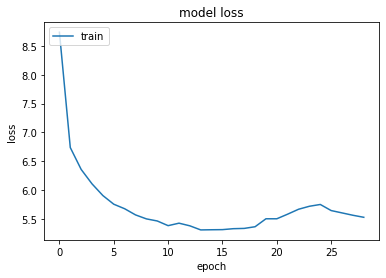

In [5]:

loss_val = [8.7381,6.7367,6.3572,6.1066,5.9032,5.7534,5.6750,5.5681,5.4989,5.4625,5.3812,5.4243,5.3783,5.3073,5.3101,5.3123,5.3286,5.3335,5.3625,5.5006,5.5006,5.5810,5.6660,5.7179,5.7489,5.6431,5.6025,5.5616,5.5263]
plt.plot(loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()